# Neural Style Transfer Tutorial

Sources:
- https://www.tensorflow.org/tutorials/generative/style_transfer


Mostly from the tf tutorial on style transfer based on [original paper: A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)


In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-10-22 18:20:21.361681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-22 18:20:21.361793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


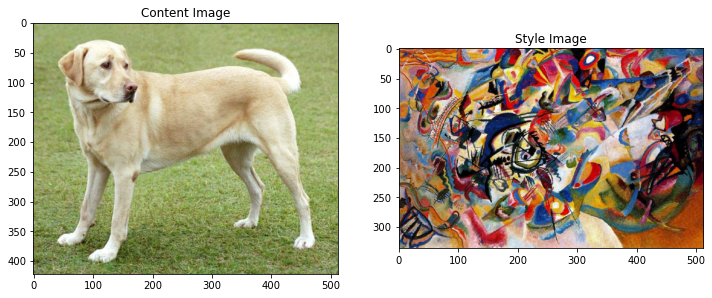

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Fast Style Transfer using TF-Hub
This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the TensorFlow Hub model does this:




2021-10-22 18:20:23.372751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-22 18:20:23.384508: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-22 18:20:23.384906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


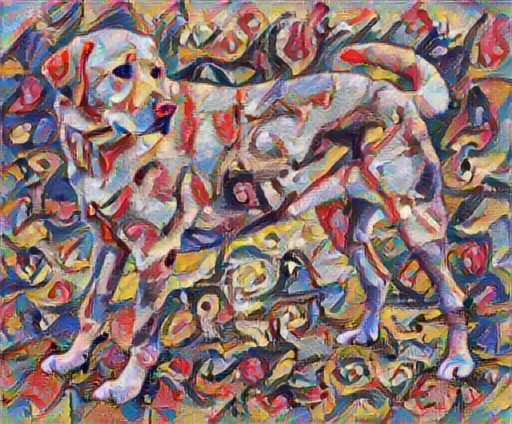

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations
Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:





In [9]:
# Preprocess our dog image to ready for the VGG19 model
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# Get the full VGG19 model with the classification top
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

# Make a prediction of our dog image on this pre-trained VGG network
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
# Display the top 5 predicted options based on our dog input from VGG19
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317437),
 ('golden_retriever', 0.236652),
 ('kuvasz', 0.036357306),
 ('Chesapeake_Bay_retriever', 0.024182605),
 ('Greater_Swiss_Mountain_dog', 0.018645976)]

In [11]:
# Now load a VGG19 without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## How to use the layers in Neural Style Transfer
* Higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but do not constrain the exact pixel values of the reconstruction.
* Reconstructions from the lower layers simply reproduce the exact pixel values of the original image

![st_paper_img1.png](st_paper_img1.png)
- **Content Reconstructions**: We find that reconstruction from lower layers is almost perfect (a,b,c). In
higher layers of the network, detailed pixel information is lost while the high-level content of the image is preserved
- **Style Reconstructions**: The style representation computes correlations between the different features in different layers of the CNN





Bottomline:
- We want to keep the high level content of the original image intact and not an exact copy like lower layers.
- Want to grab the style that is learned between the layers to apply to this higher level content image, so that the style can determine how to fill in the blanks for putting in some kind of re-construction based on that style

In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Intermediate layers for style and content
So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model
The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

model = Model(inputs, outputs)

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [13]:

# Creates a model based on specified layers you want to use. 
# E.g. layer1 and layer2 then you get back VGG with layer1 and layer2
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
# Create a VGG19 Model with only the layers we are interested in
style_extractor = vgg_layers(style_layers)

# Input our styled image into this custom VGG19 variation
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.52563
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.877
  mean:  199.82689

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78094

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.152
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2349
  mean:  59.17949



## Calculate style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

![gram_matrix.png](gram_matrix.png)



On top of the CNN responses in each layer of the network we built a style representation that computes the correlations between the different filter responses, where the expectation is taken over the spatial extend of the input image. These feature correlations are given by the Gram matrix.

To generate a texture that matches the style of a given image (Fig 1, style reconstructions),
we use gradient descent from a white noise image to find another image that matches the style
representation of the original image. This is done by minimising the mean-squared distance
between the entries of the Gram matrix from the original image and the Gram matrix of the
image to be generated



This can be implemented concisely using the tf.linalg.einsum function:



In [15]:
# Caclulate the gram matric 
def gram_matrix(input_tensor):

  # Einsum let's you specify a calculation that needs to happen in vector space like R
  # Tensor contraction over specified indices and outer product
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Extract style and content

Build a model that returns the style and content tensors.

We construct our StyleTransfer model by creating a new VGG19 model where:
- The first layers consist of the ones needed for style transfer
- The second part of layer(s) that are needed for content representation

This way we can easily index the layers we need for which part and we still have all the layers we need into 1 model

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    # Create our custom model with frist the style layers and lastly content repres.
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False


  # Call method which is used to perform a forward propagation
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Get the outputs from out custom VGG model
    outputs = self.vgg(preprocessed_input)

    # Now we can easily index by means of layer index between style and content output
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # We run the gram matrix for each style layer's output
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]


    # Create our output to use
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    # Seperate the output for both tasks to be used for gradient descent
    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

# This calls the "call()" method forward pass
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055226446
    max:  28014.568
    mean:  263.7903

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.53
    mean:  9100.951

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.5
    mean:  7660.9775

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320503.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.23
    mean:  1487.0376

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8809
    mean:  13.764149


# Run gradient descent
With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image):

In [19]:
image = tf.Variable(content_image)

# Since this is a float image, define a 
# function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:



In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


To optimize this, use a weighted combination of the two losses to get the total loss:

In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
# The loss function to use for backprop so the model 
# can learn on both tasks simultanously
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Get the ngram matrix loss for each layer
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])

    # Normalize the total loss by the number of layers and weight loss we specified 
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # Total loss can be added up 
    loss = style_loss + content_loss
    return loss

In [23]:
@tf.function()
def train_step(image):
  # Use tf.GradientTape to update the image.
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

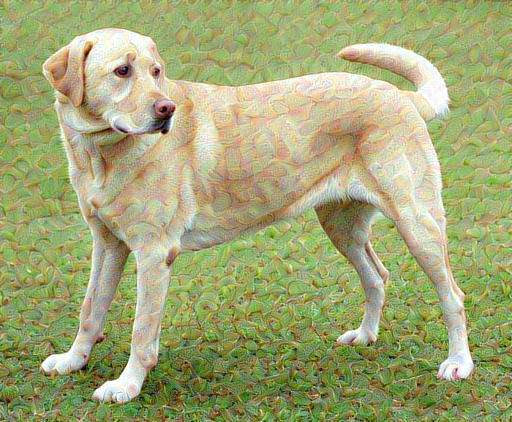

In [25]:
# Run a few steps to test
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:


In [24]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

# step = 0
# for n in range(epochs):
#   for m in range(steps_per_epoch):
#     step += 1
#     train_step(image)
#     print(".", end='', flush=True)
#   display.clear_output(wait=True)
#   display.display(tensor_to_image(image))
#   print("Train step: {}".format(step))
# 
# end = time.time()
# print("Total time: {:.1f}".format(end-start))